# Load dataset

In [1]:
import pandas as pd
from data_preprocessing import *

2023-03-15 12:42:02.758929: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
data_dir = 'data/experiment4/'

X_df = pd.read_csv(f'{data_dir}HA-ANARCI_X.csv')
y_df = pd.read_csv(f'{data_dir}HA-ANARCI_y.csv')['binding']


In [3]:
def to_tf_dataset(x, y, y_label='binding',convert_dict=None):

    x = pd.DataFrame(x)
    if convert_dict:
        x = x.replace(convert_dict)
    y = pd.Series(y).reset_index(drop=True)
    full = pd.concat([x, y],axis=1)
    full.columns = [*list(map(str,list(range(1, x.shape[1]+1)))), y_label]
    display(full.shape)
    
    return tfdf.keras.pd_dataframe_to_tf_dataset(full, label=y_label)


In [4]:

cdr_char = 'XEDRKHQNSTPGCAVILMFYW-'
test_size = 0.1

pad_len = []
for c in X_df[['VH_AA','VL_AA']]:
    pad_len.append(X_df[c].str.len().max())

codes_dict = {i: c for i, c in enumerate(cdr_char)}


In [5]:

X_df, y_df = subsample_stemhead(X_df, y_df)

[train_set, val_set, test_set], [X_train_id, X_eval_id, X_test_id], le = encode(X_df, y_df, cdr_char, test_size, pad_len)
[train_set_tf, val_set_tf, test_set_tf] = [to_tf_dataset(x, y, convert_dict=codes_dict) for (x,y) in [train_set, val_set, test_set]] ## debug


(709, 376)

/home/yhyeung2/anaconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1001: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  (dict(dataframe.drop(label, 1)), dataframe[label].values))
2023-03-15 12:42:06.454599: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-15 12:42:06.511154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:ca:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 715.34GiB/s
2023-03-15 12:42:06.511206: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-15 12:42:06.513751: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcubla

(79, 376)

/home/yhyeung2/anaconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1001: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  (dict(dataframe.drop(label, 1)), dataframe[label].values))


(88, 376)

/home/yhyeung2/anaconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1001: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  (dict(dataframe.drop(label, 1)), dataframe[label].values))


In [6]:
from tensorflow.keras.utils import to_categorical

(train_x, y_train), (val_x, y_val), (test_x, y_test) = [train_set, val_set, test_set]
y_train, y_val, y_test = to_categorical(y_train), to_categorical(y_val), to_categorical(y_test)
input_length = train_x.shape[1]

# Train

In [7]:
from tensorflow.keras import backend as K
from model_training import *


## deep learning models

### transformer model

In [11]:
K.clear_session()
CDR_model = CDR_model_single(max_length=input_length, n_classes=3)
CDR_model, CDR_history = train_dl_multi(CDR_model, (train_x, y_train), (val_x, y_val))


2023-03-14 05:02:09.486594: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-14 05:02:09.505732: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400000000 Hz
2023-03-14 05:02:12.762149: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-14 05:02:13.580607: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-03-14 05:02:13.581407: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [12]:
eval_df, pred, (label, pred_bool) = test_model_multi(CDR_model, (test_x, y_test, X_test_id), le)
display(eval_df)

(88, 3)


False    50
True     38
dtype: int64

,Id,Label,Prediction,Probability Stem,Probability Head,Probability Others
141,16.a.37_Heavy,others,head,0.297971,0.366142,0.335888
261,01.d.02_Heavy,others,head,0.297963,0.366153,0.335883
142,31.a.65_Heavy,others,head,0.297966,0.366148,0.335886
270,31.a.16_Heavy,others,head,0.297966,0.366148,0.335887
31,C1-2-C06,others,head,0.297954,0.366159,0.335887
231,K77-2A06,others,head,0.297970,0.366141,0.335890
103,K77-1C11,others,head,0.297969,0.366144,0.335887
113,SFV015_1F04,others,head,0.297966,0.366148,0.335886
150,R95-2F11,others,head,0.297972,0.366147,0.335881
215,16.a.92_Heavy,others,head,0.297973,0.366149,0.335878


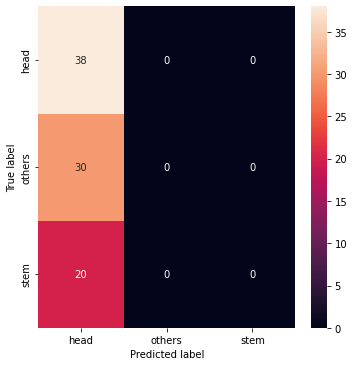

In [13]:
plot_cm_multi(label, pred_bool, le)

### feed forward network

In [14]:
# dense 

K.clear_session()
CDR_model = CDR_model_dense(max_length=input_length, n_classes=3)
CDR_model, CDR_history = train_dl_multi(CDR_model, (train_x, y_train), (val_x, y_val))



In [15]:

eval_df, pred, (label, pred_bool) = test_model_multi(CDR_model, (test_x, y_test, X_test_id), le)
display(eval_df)

(88, 3)


True     51
False    37
dtype: int64

,Id,Label,Prediction,Probability Stem,Probability Head,Probability Others
812,R95-2A08,head,stem,0.408810,0.321843,0.269347
874,641_I-9,head,others,0.343494,0.274925,0.381581
553,014_10_1B04,head,stem,0.378919,0.329735,0.291346
669,H1N1_300-16-IgG-2E02_,head,stem,0.442492,0.377721,0.179787
825,W85-3G03,head,others,0.314817,0.268821,0.416362
701,150055-008_1C03,head,stem,0.511556,0.222988,0.265456
674,13001-07_4D05,head,stem,0.512273,0.235193,0.252535
679,13001-07_5G01,head,stem,0.433923,0.353852,0.212224
851,1000-3E01,head,stem,0.441327,0.161475,0.397198
716,150055-015_1G03,head,stem,0.447380,0.260418,0.292201


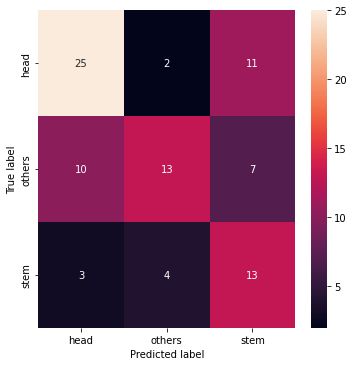

In [16]:
plot_cm_multi(label, pred_bool, le)

### random forest

In [24]:
# save model

# model_save_dir = 'models/exp4_random_forest'
# if not os.path.exists(model_save_dir):
#     os.makedirs(model_save_dir)

# CDR_model.save(model_save_dir)



# load model
model_load_dir = 'models/exp4_random_forest'
CDR_model_multi = tf.keras.models.load_model(model_load_dir, 
                                             custom_objects={
                                                 'recall_m': recall_m,
                                                 'precision_m': precision_m,
                                                 'f1_score': f1_score
                                             })
CDR_model = CDR_model_multi

[INFO kernel.cc:929] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 300 root(s), 33198 node(s), and 212 input feature(s).
[INFO abstract_model.cc:876] Engine "RandomForestGeneric" built
[INFO kernel.cc:797] Use fast generic engine


In [23]:
# skip if loaded pre-trained model

def train_tree_multi(CDR_model, train, val):

    CDR_model.compile(
        metrics=[
            CategoricalAccuracy(name='accuracy'),
            precision_m, 
            recall_m,
            AUC(name='auc'),
            AUC(name='prc', curve='PR'),
            ])

    callbacks = [EarlyStopping(patience=10, restore_best_weights=True)]

    CDR_history=CDR_model.fit(
        x=train,
        validation_data=val,
        callbacks=callbacks,
        verbose=0
    )

    return CDR_model, CDR_history


K.clear_session()
CDR_model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)
CDR_model, CDR_history = train_tree_multi(CDR_model, train_set_tf, val_set_tf)


[INFO kernel.cc:727] Start Yggdrasil model training
[INFO kernel.cc:728] Collect training examples
[INFO kernel.cc:389] Number of batches: 12
[INFO kernel.cc:390] Number of examples: 709
[INFO data_spec_inference.cc:286] 3 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 1 (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:286] 9 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 10 (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:286] 3 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 101 (12 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:286] 9 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 104 (7 item(s) left) because min_value_count=5 and max_number_of_unique_values=

[INFO kernel.cc:929] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 300 root(s), 33822 node(s), and 211 input feature(s).
[INFO abstract_model.cc:876] Engine "RandomForestGeneric" built
[INFO kernel.cc:797] Use fast generic engine


In [27]:

eval_df, pred, (label, pred_bool) = test_model_multi(CDR_model, (test_set_tf, y_test, X_test_id), le)
display(eval_df)


(88, 3)


True     82
False     6
dtype: int64

,Id,Label,Prediction,Probability Stem,Probability Head,Probability Others
674,13001-07_4D05,head,others,0.240000,0.303333,0.456666
818,W85-1C09,head,others,0.076667,0.183333,0.739999
679,13001-07_5G01,head,stem,0.366666,0.293333,0.340000
150,R95-2F11,others,head,0.180000,0.536666,0.283333
202,R95-1D06,others,head,0.136667,0.659999,0.203333
31,C1-2-C06,others,stem,0.396666,0.280000,0.323333


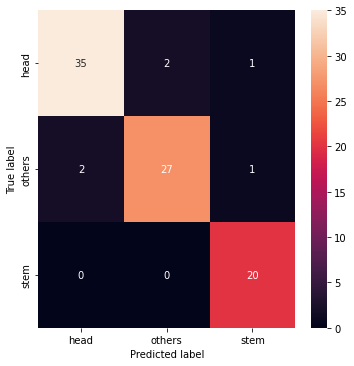

In [29]:
plot_cm_multi(label, pred_bool, le)

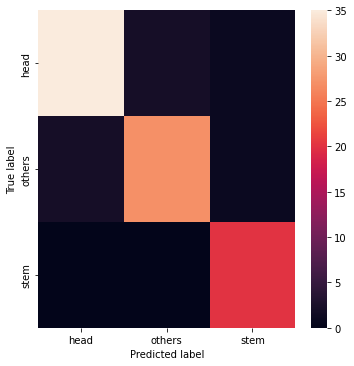

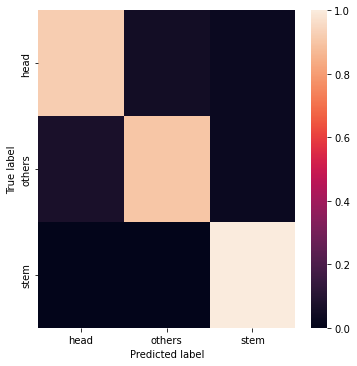

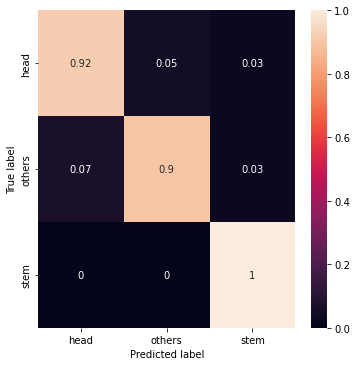

In [28]:
plot_cm_multi(label, pred_bool, le, annot=False)
plot_cm_multi(label, pred_bool, le, relative=True, annot=False)
plot_cm_multi(label, pred_bool, le, relative=True)

# Visualize

## extract decision tree rules

In [16]:
from viz_tree import *

In [20]:
# following tfdf library's default

num_trees = 300
max_depth = 16

rule_df = extract_tree(CDR_model, num_trees, max_depth)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [02:58<00:00,  1.68it/s]


## plot

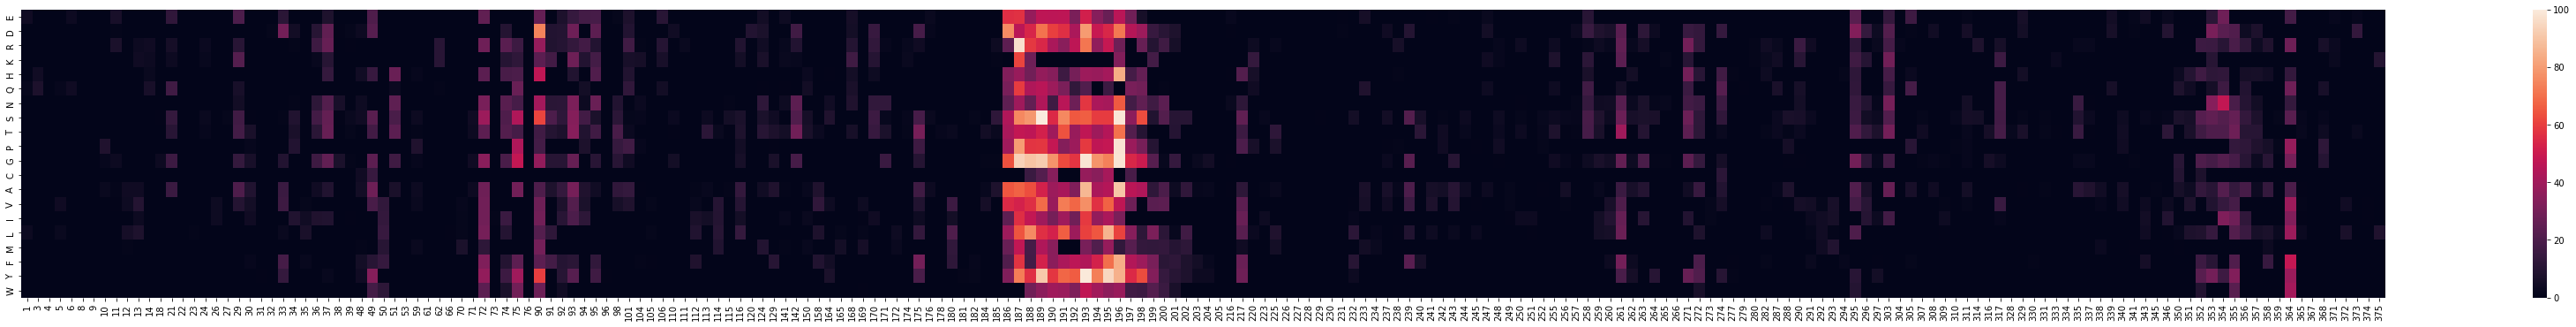

In [21]:
draw_heatmap(rule_df)

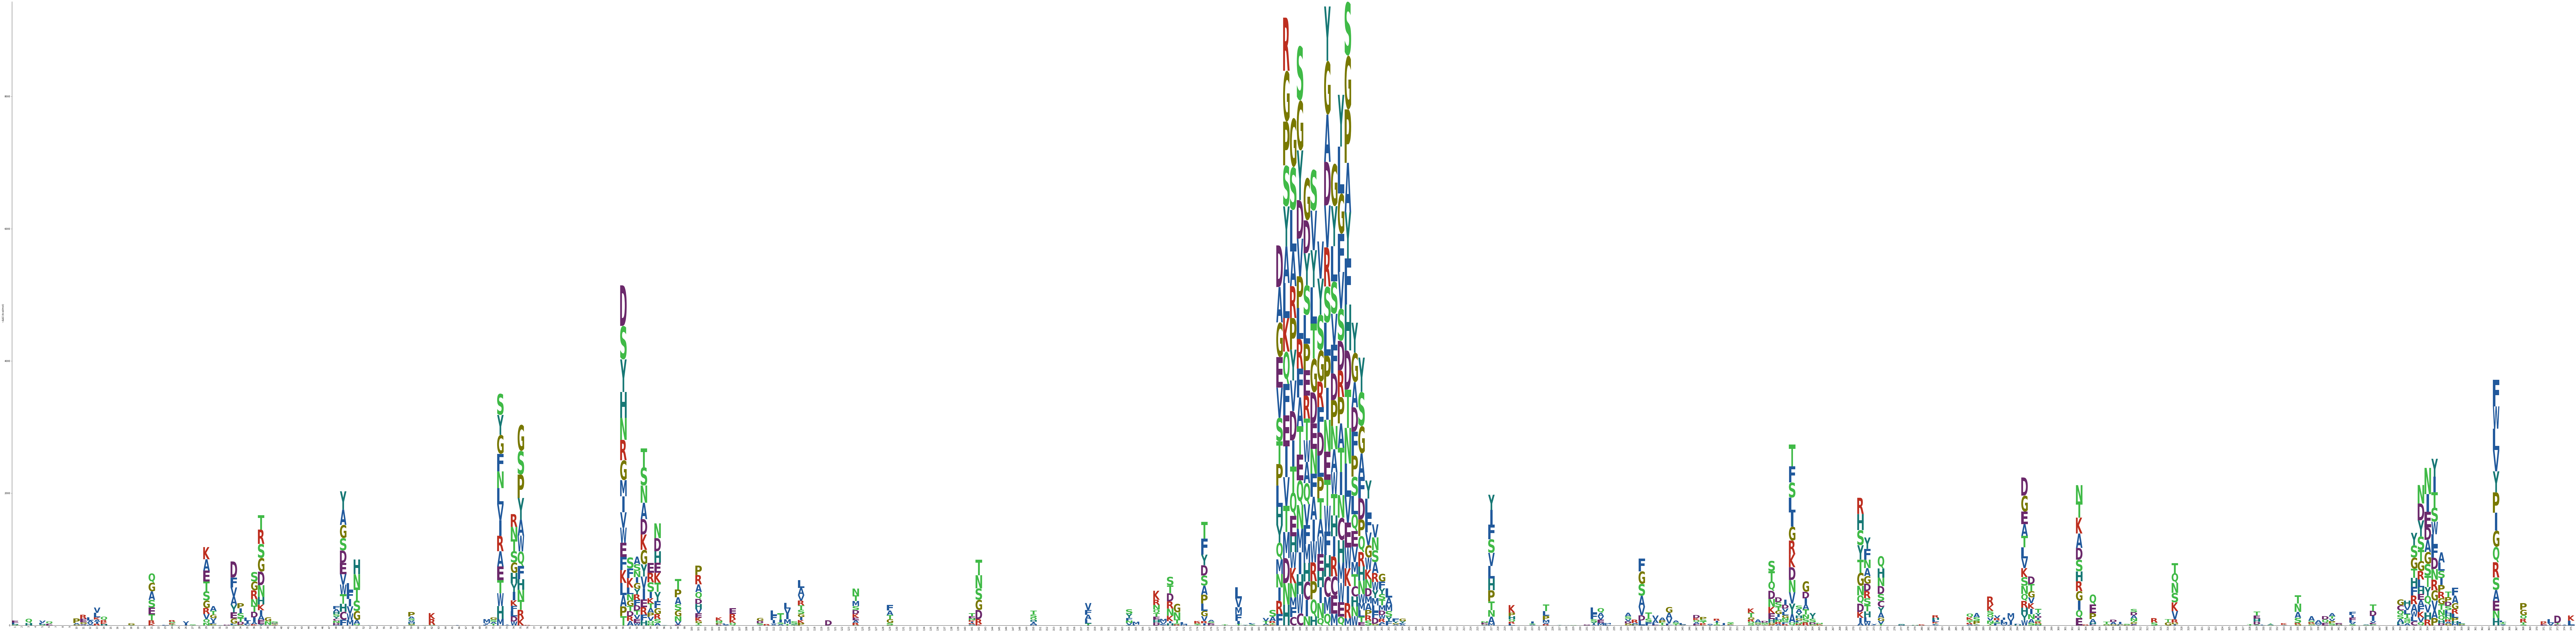

In [22]:
logosequence(rule_df)